***https://colab.research.google.com/drive/15ArMT2DOSrBPkk9Y6f9NLanXijJwix7K?usp=sharing#scrollTo=wPYjDMkDliRa***

Our submission includes a PDF containing around 5 pages of explanatory text in addition to the code.

On Kaggle, our valid team name is "Tench Qian". The team "TQ" was unintentionally created and does not represent a competing team—please disregard it. Thank you for your understanding.

**Introduction**

In this project, we predict energy consumption in HVAC Systems using LSTM and Autoregressive Approaches.

The energy consumption of HVAC systems exhibits significant time-dependent characteristics, influenced by historical usage patterns, environmental factors, and temporal features. Recurrent Neural Networks (RNNs), particularly their variant Long Short-Term Memory (LSTM) networks, are highly effective at capturing long-term dependencies in sequential data, enabling more accurate predictions of future energy consumption.

Since the goal extends beyond predicting immediate energy usage to forecasting future trends, the autoregressive approach becomes essential. By feeding the model’s own predictions back into the input sequence, we can iteratively estimate future consumption levels.

Combining LSTM’s robust sequence modeling with autoregressive forecasting allows the model to learn complex temporal patterns from historical energy data and external features. This facilitates both single-step and multi-step energy consumption predictions, supporting optimized HVAC operation and energy efficiency.

LSTM’s strength in handling long-term memory is particularly valuable for analyzing seasonal, cyclical, and trend-based variations in HVAC energy usage. Meanwhile, the autoregressive method ensures reliable future projections even when precise external factor forecasts are unavailable, which is a practical advantage in real-world applications.

In [ ]:
# ==================== 1. Installation and Import ====================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ==================== 2. Upload Data ====================
train_df = pd.read_csv('/content/sample_data/train_dataset.csv')
test_df = pd.read_csv('/content/sample_data/test_features.csv')


**Fearture Engineering**

We extract temporal and directional features from the original timestamps and wind direction values. The following transformations are used:
- Time Features: From the date field, we derive:
- hour : the hour of the day,
- dayofweek : the day of the week ( $0=$ Monday, $\ldots, 6=$ Sunday $)$,
- We then apply sine and cosine transformations to encode cyclical patterns:

$$
\begin{array}{cc}
\text { hour_sin }=\sin \left(\frac{2 \pi \cdot \text { hour }}{24}\right), & \text { hour_cos }=\cos \left(\frac{2 \pi \cdot \text { hour }}{24}\right) \\
\text { day_sin }=\sin \left(\frac{2 \pi \cdot \text { dayofweek }}{7}\right), & \text { day_cos }=\cos \left(\frac{2 \pi \cdot \text { dayofweek }}{7}\right)
\end{array}
$$

- Wind Direction: Similarly, the direction_vent field (in degrees) is mapped to its circular components:

$$
\begin{array}{cc}
\text { direction_vent_sin }=\sin \left(\frac{2 \pi \cdot \text { direction_vent }}{360}\right), \quad \text { direction_vent_cos }=\cos \left(\frac{2 \pi \cdot \text { direction_vent }}{360}\right)
\end{array}
$$


We do not include month-based cyclic encodings, because the data only spans 12 months in a single year and does not contain seasonal year-to-year variability.

**Feature Selection and Normalization**

The following numerical and engineered features are selected:
- Environmental features: temperature_exterieure, humidite, ensoleillement, vitesse_vent, temperature_interieure
- Time: hour_sin, hour_cos, day_sin, day_cos
- Wind Direction: direction_vent_sin, direction_vent_cos
- Past HVAC power: puissance_cvac

Each feature is standardized using z-score normalization:

$$
x_{\text {scaled }}=\frac{x-\mu}{\sigma}
$$

where $\mu$ and $\sigma$ are the sample mean and standard deviation respectively. The same scaler is reused for the test data.

In [ ]:
# ==================== 3. Feature engineering ====================
def add_time_features(df):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df[df['date'].notna()].reset_index(drop=True)
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    df['direction_vent'] = pd.to_numeric(df['direction_vent'], errors='coerce')
    df['direction_vent_sin'] = np.sin(2 * np.pi * df['direction_vent'] / 360)
    df['direction_vent_cos'] = np.cos(2 * np.pi * df['direction_vent'] / 360)
    return df

train_df = add_time_features(train_df)
test_df = add_time_features(test_df)

# ==================== 4. Base Features & Scaling ====================
base_features = [
    'temperature_exterieure', 'humidite', 'ensoleillement', 'vitesse_vent', 'temperature_interieure',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'direction_vent_sin', 'direction_vent_cos'
]

for col in base_features + ['puissance_cvac']:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce')

train_df = train_df.dropna(subset=base_features + ['puissance_cvac']).reset_index(drop=True)
test_df = test_df.ffill().bfill().reset_index(drop=True)

scaler_feat = StandardScaler()
scaler_cvac = StandardScaler()

train_X_base = scaler_feat.fit_transform(train_df[base_features]).astype(np.float32)
train_Y_cvac = scaler_cvac.fit_transform(train_df[['puissance_cvac']]).astype(np.float32)
test_X_base = scaler_feat.transform(test_df[base_features]).astype(np.float32)

**Autoregressive Input Design and Model Usage**

In our autoregressive setup, we construct input sequences of the form:

$$
\{v_{t-l}, v_{t-l+1}, \dots, v_{t-1}\} \mapsto \hat{y}_t
$$

where each vector $ v_t \in {R}^{12} $ includes:

- 11 base features (e.g., external temperature, humidity, solar radiation, time and wind features), and  
- 1 endogenous variable: the past value of HVAC consumption $ y_t = \texttt{puissance_cvac}_t $

The full autoregressive input at time $ t $ is a sequence of these vectors of length $ l = 16 $, combining both exogenous and endogenous signals.

> **Important distinction**: Although the same ARLSTM model is used for both tasks, the composition of $ v_t $ slightly differs between the `cvac` and `future` forecasting stages:

- **Training and one-step prediction (`cvac`)**:  
  All $ v_t $ vectors are constructed from true historical values — both features and HVAC consumption are known.

- **Recursive multi-step prediction (`future`)**:  
  After the first step, future $ v_t $ vectors are constructed with predicted HVAC values (that is, the model outputs are recursively fed back into the input sequence). **This may introduce accumulated uncertainty**.

**Mitigating Error Accumulation in Multi-Step Forecasting: A Hybrid Approach**

**1. Limitations of Pure Autoregressive Forecasting**

When relying solely on a single future model that recursively uses its own predictions as historical cvac inputs:

- Error Propagation: Each prediction step (e.g., from t to t+1) introduces a small error.

- Compounding Effect: For subsequent steps (e.g., t+2, t+3), these errors accumulate in the input history, progressively degrading forecast accuracy.

- Divergence: Over longer horizons, predictions may deviate significantly from true values due to this snowballing effect.

**2. Role of the CVAC Model as an Anchor**

The cvac model addresses this by: Providing Grounded Estimates: At each timestep m, it supplies a current_cvac value based on actual historical data (or one-step-ahead predictions), serving as a "reality check." Resetting Error Accumulation: By restarting the future model at m+1 with the cvac model’s output (instead of the future model’s prior prediction), we anchor predictions to a more reliable starting point. Prevent autoregressive errors from propagating indefinitely.

**3. Error-Control Mechanism**
This hybrid approach functions similarly to a periodic calibration:

- Frequency: At every new timestep (e.g., hourly), the cvac model "refreshes" the input with its best available estimate.

- Impact: Even imperfect cvac estimates (e.g., from one-step forecasts) constrain error growth by:

- Breaking the chain of self-referential predictions and introducing external information to correct drifts.



In [ ]:
# ==================== 5. Constructing an autoregressive dataset ====================
SEQ_LEN_CURRENT = 16  # Time window for estimation of the missing current CVAC in testing data
SEQ_LEN_FUTURE = 16   # Time window for prediction of the future CVAC
SEQ_LEN_TRAIN = max(SEQ_LEN_CURRENT, SEQ_LEN_FUTURE)
X_seq, X_cvac, Y = [], [], []
for i in range(SEQ_LEN_TRAIN, len(train_X_base)):
    X_seq.append(train_X_base[i-SEQ_LEN_TRAIN:i])
    X_cvac.append(train_Y_cvac[i-SEQ_LEN_TRAIN:i])
    Y.append(train_Y_cvac[i])
X_full = np.concatenate([X_seq, X_cvac], axis=-1)
Y = np.array(Y)

class AutoregressiveDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.squeeze(), dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_X_full, val_X_full, train_Y, val_Y = train_test_split(X_full, Y, test_size=0.2, shuffle=False)

# During model training, we enable shuffle=True to randomize the order of samples at the start of each epoch.
train_dataset = AutoregressiveDataset(train_X_full, train_Y)
val_dataset = AutoregressiveDataset(val_X_full, val_Y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


**LSTM Model & AR-LSTM Model**

We use a manually defined LSTM to process sequential inputs. At each time step $t$, given input $\boldsymbol{x}_t$ and previous hidden state $\boldsymbol{h}_{t-1}$, cell state $\boldsymbol{c}_{t-1}$, the cell computes:

- Forget gate: $f_t=\sigma\left(W_f\left[x_t, h_{t-1}\right]\right)$

- Input gate: $i_t=\sigma\left(W_i\left[x_t, h_{t-1}\right]\right)$

- Cell candidate: $\tilde{c}_t=\tanh \left(W_c\left[x_t, h_{t-1}\right]\right)$

- Cell update: $c_t=f_t \cdot c_{t-1}+i_t \cdot \tilde{c}_t$

- Output gate: $o_t=\sigma\left(W_o\left[x_t, h_{t-1}\right]\right)$

- Hidden state: $h_t=o_t \cdot \tanh \left(c_t\right)$

- Only the last hidden state $h_T$ is passed to a final linear layer to produce a scalar output $\hat{y}_t \in \mathbb{R}$.

The ARLSTM model consists of:
- An LSTM encoder that processes sequences of shape $(B, l, d)$, where:
- $B$ : batch size
- $l=16$ : number of time steps
- $d=$ number of features $=12$
- A fully connected layer maps the final hidden state to a scalar prediction.

In [ ]:
# ==================== 6. LSTM model definition ====================
class ManualLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout)
        self.W_f = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_i = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_o = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_c = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h_t = torch.zeros(batch_size, self.hidden_size, device=x.device)
        c_t = torch.zeros(batch_size, self.hidden_size, device=x.device)
        for t in range(seq_len):
            x_t = x[:, t, :]
            combined = torch.cat([x_t, h_t], dim=1)
            f_t = torch.sigmoid(self.W_f(combined))
            i_t = torch.sigmoid(self.W_i(combined))
            o_t = torch.sigmoid(self.W_o(combined))
            c_hat = torch.tanh(self.W_c(combined))
            c_t = f_t * c_t + i_t * c_hat
            h_t = o_t * torch.tanh(c_t)
            h_t = self.dropout(h_t)
        return h_t # Return the hidden state at the last time step

# ==================== 7. AR-LSTM model definition ====================
class ARLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.lstm = ManualLSTM(input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out = self.lstm(x) # Shape: (batch_size, hidden_dim)
        return self.fc(out).squeeze(-1) # Shape: (batch_size)


**Training Strategy**

- Loss Function: Mean Squared Error (MSE),

$$
\mathcal{L}(y, \hat{y})=\frac{1}{n} \sum_{i=1}^n\left(y_i-\hat{y}_i\right)^2
$$

- Optimizer: Adam, an adaptive gradient-based optimization algorithm with momentum, which updates weights via:

$$
\begin{aligned}
m_t & =\beta_1 m_{t-1}+\left(1-\beta_1\right) g_t \\
v_t & =\beta_2 v_{t-1}+\left(1-\beta_2\right) g_t^2 \\
\theta_t & =\theta_{t-1}-\eta \cdot \frac{m_t}{\sqrt{v_t}+\epsilon}
\end{aligned}
$$

- Early Stopping: Training is stopped if validation loss does not improve after 7 epochs.
- Learning Rate Scheduler: Reduces learning rate by a factor of 0.5 if validation loss plateaus.

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Train Loss: 0.2924, Validation Loss: 0.0769
Epoch 2, Train Loss: 0.0452, Validation Loss: 0.0487
Epoch 3, Train Loss: 0.0337, Validation Loss: 0.0433
Epoch 4, Train Loss: 0.0299, Validation Loss: 0.0401
Epoch 5, Train Loss: 0.0281, Validation Loss: 0.0385
Epoch 6, Train Loss: 0.0261, Validation Loss: 0.0360
Epoch 7, Train Loss: 0.0251, Validation Loss: 0.0341
Epoch 8, Train Loss: 0.0239, Validation Loss: 0.0332
Epoch 9, Train Loss: 0.0229, Validation Loss: 0.0304
Epoch 10, Train Loss: 0.0218, Validation Loss: 0.0288
Epoch 11, Train Loss: 0.0207, Validation Loss: 0.0282
Epoch 12, Train Loss: 0.0198, Validation Loss: 0.0264
Epoch 13, Train Loss: 0.0188, Validation Loss: 0.0248
Epoch 14, Train Loss: 0.0180, Validation Loss: 0.0238
Epoch 15, Train Loss: 0.0175, Validation Loss: 0.0222
Epoch 16, Train Loss: 0.0170, Validation Loss: 0.0212
Epoch 17, Train Loss: 0.0161, Validation Loss: 0.0204
Epoch 18, Train Loss: 0.0156, Validation Loss: 0.0196
Epoch 19, Train Loss: 0.0153, Validat

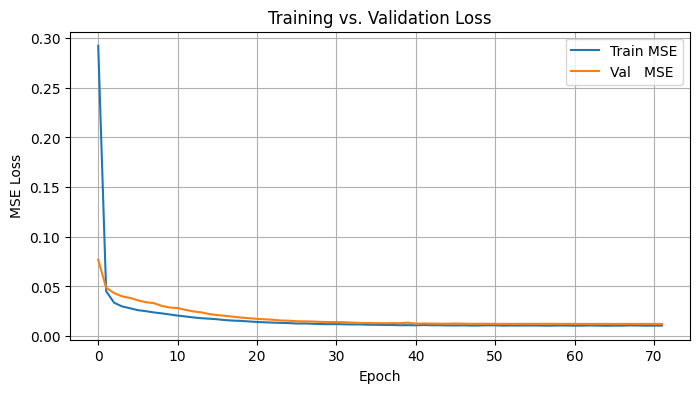

In [ ]:
# ==================== 8. Model training with early stopping ====================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = len(base_features) + 1
model = ARLSTM(input_dim=input_dim, hidden_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=7e-5)
criterion = nn.MSELoss()

patience = 7
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# prepare lists to record loss
train_history = []
val_history = []

for epoch in range(300):
    model.train()
    train_losses = []
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        loss = criterion(model(x_batch), y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    avg_train_loss = np.mean(train_losses)

    model.eval()
    val_losses = []
    with torch.no_grad():
        for x_val_batch, y_val_batch in val_loader:
            x_val_batch, y_val_batch = x_val_batch.to(device), y_val_batch.to(device)
            val_loss = criterion(model(x_val_batch), y_val_batch)
            val_losses.append(val_loss.item())
    avg_val_loss = np.mean(val_losses)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            model.load_state_dict(best_model_state)
            break

    scheduler.step(avg_val_loss)
    train_history.append(avg_train_loss)
    val_history.append(avg_val_loss)

# —— new plotting block ——
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(train_history, label='Train MSE')
plt.plot(val_history,   label='Val   MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()



**Loss curves**: Both training and validation MSE drop rapidly in the first few epochs and then taper off to roughly the same low value, with no growing gap. This indicates that the model is converging and generalizing rather than memorizing.



**Recursive Rolling Forecast: One-step Prediction**

We predict one time-step ahead using the last $l=16$ observed values. Then we append the prediction to the sequence and roll the window forward.

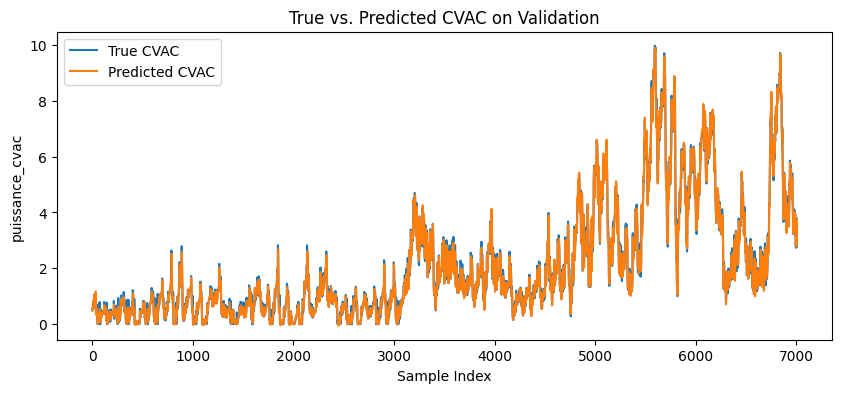

In [ ]:
# ==================== 9. Rolling Forecast for puissance_cvac ====================
cvac_preds = []
feat_hist = train_X_base[-SEQ_LEN_CURRENT:]
cvac_hist = train_Y_cvac[-SEQ_LEN_CURRENT:]

if best_model_state is not None:
    model.load_state_dict(best_model_state)
model.eval()
with torch.no_grad():
    for t in range(len(test_df)):
        if t < SEQ_LEN_CURRENT:
            feat_window = np.concatenate([feat_hist[t:], test_X_base[:t]], axis=0)
            cvac_window = np.concatenate([cvac_hist[t:], np.array(cvac_preds)[:t].reshape(-1, 1)], axis=0)
        else:
            feat_window = test_X_base[t-SEQ_LEN_CURRENT+1:t+1]
            cvac_window = np.array(cvac_preds[-SEQ_LEN_CURRENT:]).reshape(-1, 1)
        x_input = np.concatenate([feat_window, cvac_window], axis=1).reshape(1, SEQ_LEN_CURRENT, -1)
        x_tensor = torch.tensor(x_input, dtype=torch.float32).to(device)
        y_hat = model(x_tensor).cpu().item()
        cvac_preds.append(y_hat)

cvac_preds_inv = scaler_cvac.inverse_transform(np.array(cvac_preds).reshape(-1, 1)).flatten()

# puissance_cvac
submission_cvac = pd.DataFrame({
    'ID': test_df['ID'],
    'puissance_cvac_pred': cvac_preds_inv
})
submission_cvac.to_csv("submission_cvac.csv", index=False)

# Plot Predicted vs. Actual on your held‑out validation set
true_vals = scaler_cvac.inverse_transform(val_Y.reshape(-1, 1)).flatten()
preds_inv = scaler_cvac.inverse_transform(
    np.array([
        model(
            torch.tensor(x.reshape(1, SEQ_LEN_CURRENT, -1), dtype=torch.float32)
                  .to(device)
        ).cpu().item()
        for x in val_X_full
    ]).reshape(-1, 1)
).flatten()

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(true_vals, label='True CVAC')
plt.plot(preds_inv,  label='Predicted CVAC')
plt.xlabel('Sample Index')
plt.ylabel('puissance_cvac')
plt.title('True vs. Predicted CVAC on Validation')
plt.legend()
plt.show()

**True vs. Predicted CVAC:** The orange forecast line tracks the blue ground‑truth almost perfectly across the entire validation sequence—from low‑variance periods through spikes—showing that the model captures both the level and the dynamics of the signal.


**Recursive Forecasting: +16 Step Future Prediction**

First, we want to justify for using training data segments in early test phase.
Given the limited historical data available at the start of the test set, extracting relevant segments from the training data serves as a reasonable approximation for the following reasons:

1. Assumption of Cyclical Patterns :
Time-series data often exhibit cyclical trends (e.g., daily or weekly periodicity). When historical data is insufficient in the initial test phase, segments from the training set particularly those from similar time windows (e.g., the same hour of the day or adjacent days), can provide a reliable estimate of expected patterns. This approach is supported by our observations, there are strong similarities between corresponding periods in the training data.

2. Model Generalization from Training :
Since the model has already learned cyclical dependencies during training, leveraging analogous training segments for early test-phase predictions allows it to apply its generalization capability. Even with incomplete historical data, the model can still produce reasonable forecasts by relying on previously recognized patterns rather than requiring a full test-set history.

To predict puissance_cvac_future, we simulate the autoregressive process over 16 steps. For each future step $s=1, \ldots, 16$, we:
1. Predict future HVAC consumption at $t+s$,
2. Append this value to the history window,
3. As a simplifying assumption, we presume that future values of key features (e.g., temperature, wind speed) over only the next 4 hours are available (e.g., through short-term forecasts forecast system or expert guidance) and can be utilized in the prediction process. If reliable forecasts for these features are unavailable, we may alternatively assume they remain constant throughout the prediction window or use the most recently observed values.

It is important to note that for the initial step of future current_cvac predictions, we rely on historically observed cvac values (in the early stages of the test set, may include one-step-ahead predictions from the cvac model). However, during the autoregressive phase of future forecasting, subsequent time steps will use only the future model’s own prior predictions as inputs—not the one-step-ahead cvac model’s forecasts for future time steps. This approach ensures that the future prediction process simulates real-world scenarios where no prior knowledge of future cvac values is available.


Only the prediction at $t+16$ is retained for evaluation and submission.

In [ ]:
# ==================== 10. Autoregressive training for puissance_cvac_future (+16 steps)  ====================
cvac_future_preds_step_16 = []
n_future_steps = 16

if best_model_state is not None:
    model.load_state_dict(best_model_state)
model.eval()
with torch.no_grad():
    for i in range(len(test_df)):
        future_preds_current_id = []
        # We initialize using the history information of the current time step
        if i < SEQ_LEN_FUTURE:
            # For the first few time steps of the test set, historical information is insufficient, so the last data of the training set is used to fill in the gaps.
            hist_feat = np.concatenate([train_X_base[-SEQ_LEN_FUTURE + i:], test_X_base[:i]], axis=0)
            hist_cvac = np.concatenate([train_Y_cvac[-SEQ_LEN_FUTURE + i:], np.array(cvac_preds)[:i].reshape(-1, 1)], axis=0)
        else:
            hist_feat = test_X_base[i - SEQ_LEN_FUTURE + 1:i + 1]
            hist_cvac = np.array(cvac_preds[i - SEQ_LEN_FUTURE + 1:i + 1]).reshape(-1, 1)

        current_feat_window = hist_feat[-SEQ_LEN_CURRENT:]
        current_cvac_window = hist_cvac[-SEQ_LEN_CURRENT:]

        for step in range(n_future_steps):
            # Forecast using the latest historical features and predicted CVAC values
            input_seq = np.concatenate([current_feat_window, current_cvac_window], axis=1).reshape(1, SEQ_LEN_CURRENT, -1)
            input_tensor = torch.tensor(input_seq, dtype=torch.float32).to(device)
            next_cvac_scaled = model(input_tensor).cpu().item()
            future_preds_current_id.append(next_cvac_scaled)

            # Update the history window, using the actual future features from the test set (if available)
            # and the model's predicted future CVAC value (autoregression)
            next_feat = test_X_base[min(i + 1 + step, len(test_X_base) - 1)] if len(test_X_base) > 0 else train_X_base[-1]
            current_feat_window = np.vstack([current_feat_window[1:], next_feat])
            current_cvac_window = np.vstack([current_cvac_window[1:], [next_cvac_scaled]])

        # We keep only the prediction at step 16
        cvac_future_preds_step_16.append(future_preds_current_id[-1])

# Denormalize the predicted future value
cvac_future_preds_inv_step_16 = scaler_cvac.inverse_transform(np.array(cvac_future_preds_step_16).reshape(-1, 1)).flatten()

# Construct submission DataFrame
submission_future_df_step_16 = pd.DataFrame({
    'ID': test_df['ID'],
    'puissance_cvac_future': cvac_future_preds_inv_step_16
})

# Save
submission_future_df_step_16.to_csv("submission_future.csv", index=False)
print("The forecast is complete and submission_cvac.csv and submission_future.csv are saved.")

The forecast is complete and submission_cvac.csv and submission_future.csv are saved.


### Hyperparameter Settings

- **Sequence length** (`SEQ_LEN_CURRENT = 16`, `SEQ_LEN_FUTURE = 16`)  
  Captures the most recent 16 time‑steps for both imputing the current CVAC and forecasting future values.

- **Hidden dimension** (`hidden_dim = 128`)  
  Doubled from 64 to give the LSTM more capacity to model complex temporal patterns.

- **Dropout** (`p = 0.2` in `ManualLSTM`)  
  Regularizes the recurrent hidden state to prevent over‑fitting.

- **Batch size** (`batch_size = 64`)  
  Balances gradient‐estimate stability against GPU memory constraints.

- **Learning rate** (`lr = 7e-5`)  
  Slightly lower than the previous 9e-5 to ensure smoother, more stable convergence.

- **Optimizer** (`Adam`)  
  Provides adaptive per‐parameter learning rates for faster training.

- **Loss function** (`MSELoss`)  
  Standard choice for regression targets like CVAC.

- **LR scheduler** (`ReduceLROnPlateau(factor=0.5, patience=2)`)  
  Cuts the learning rate in half when validation loss stalls for two epochs, allowing finer adjustments later.

- **Early stopping** (`patience = 7`)  
  Halts training if validation loss doesn’t improve for seven consecutive epochs, preventing over‑training.

- **Maximum epochs** (`max_epochs = 300`)  
  Upper bound that’s rarely reached thanks to early stopping.

---

### Why These Choices?

1. **Temporal window of 16 steps** strikes a good trade‑off between capturing short‑term dependence and keeping the model lightweight.  
2. **Hidden size of 128** gives the network sufficient capacity to learn nonlinear relationships without blowing up the parameter count.  
3. **Low dropout (0.2)** and **early stopping** guard against over‑fitting on a relatively small dataset.  
4. **Learning rate scheduling** plus a modest initial LR lets us descend quickly at first, then fine‑tune once we’re near a minimum.  
5. **Batch size of 64** and **Adam** ensure stable, efficient gradient updates on typical GPU hardware.  


### The Other Attempted Suboptimal Model

Non-purely autoregressive (for the future model):
This future model was designed to directly predict the value at 16 time steps ahead (puissance_cvac_future) during both training and inference, rather than performing step-by-step prediction with feedback of previous outputs. Although historical puissance_cvac values were included in the input features, the model was not explicitly trained as an autoregressive model—that is, it did not iteratively use its own predictions as inputs to forecast further into the future.

Dependency on puissance_cvac_future as the training target:
The training objective was the future value puissance_cvac_future, which is directly available in the training data. This approach differs from our autoregressive strategy where the model must generate forecasts without access to the true future values. The prediction horizon was fixed at 16 steps: the model was trained to predict the value exactly 16 steps ahead. It did not learn to perform flexible multi-step predictions and struggled to capture short-term dependencies and gradual changes leading up to that point.

As a result, the scores of these suboptimal models in kaggle remained between 0.20 and 0.35.